<a href="https://colab.research.google.com/github/Pager07/TensorflowSpecialization/blob/master/C4W4-SunspotTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#Helper function

In [2]:
def plot_series(time, series,format='-', start=0, end=None):
  plt.plot(time[start:end], series[start:end],format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

#Download Data

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-08-06 12:07:03--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-08-06 12:07:03 (111 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



#Explore Data

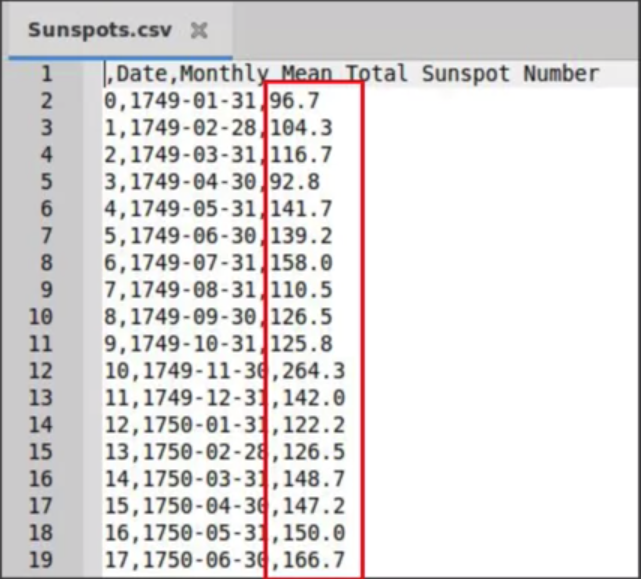

In [4]:
import csv
time_step = []
sunspots= []
with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader) # This is a easy way to skip a line, no need counters
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))
  series = np.array(sunspots)
  time = np.array(time_step)


In [5]:
series, series.shape , time, time.shape 

(array([ 96.7, 104.3, 116.7, ...,  13.2,  15.9,   1.6]),
 (3235,),
 array([   0,    1,    2, ..., 3232, 3233, 3234]),
 (3235,))

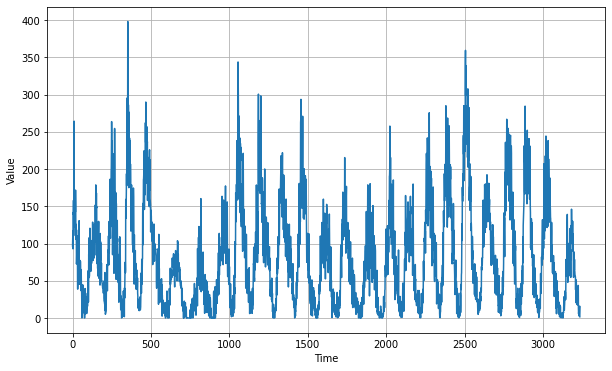

In [6]:
plt.figure(figsize=(10,6))
plot_series(time,series)

#Training and Validation Data split

In [7]:
#Training Data
split_time = 3000
time_trian = time[:split_time]
x_train = series[:split_time]

#Validation Data 
time_valid = time[split_time:]
x_valid = series[split_time:]

#Windowed Data Hyper-parameter
window_size = 30 #The can be looked as Tx?
batch_size = 32
shuffle_buffer_size = 1000

The window() method returns a dataset containing windows, where each window is itself represented as a dataset. 
- Something like {{1,2,3,4,5},{6,7,8,9,10},...}, where {...} represents a dataset. 
- But we just want a regular dataset containing tensors: {[1,2,3,4,5],[6,7,8,9,10],...}, where [...] represents a tensor. 

The flat_map() method returns all the tensors in a nested dataset, after transforming each nested dataset. 

If we didn't batch (AKA, use the .batch()), we would get: {1,2,3,4,5,6,7,8,9,10,...}. 
- By batching each window to its full size, we get {[1,2,3,4,5],[6,7,8,9,10],...} as we desired.

In [17]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1 , drop_remainder = True)
  ds = ds.flat_map(lambda w : w.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:])) #Explaination is below
  return ds.batch(batch_size).prefetch(1)


#Finding Good LR

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train,window_size,batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters=32,
                                                           kernel_size = 5,
                                                           padding='causal',
                                                           strides = 1,
                                                           activation= 'relu',
                                                           input_shape=[None,1]), #Samples x F X Channels. Give last 2
                                    tf.keras.layers.LSTM(64,return_sequences=True),
                                    tf.keras.layers.LSTM(64,return_sequences=True),
                                    tf.keras.layers.Dense(30,activation='relu'),
                                    tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x:x*400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

optimizer = tf.keras.optimizers.SGD(lr=1e-8,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule]) #train_set is tensorflow dataset obj

(1e-08, 0.0001, 0.0, 60.0)

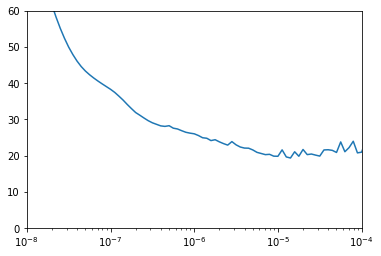

In [26]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

#Model

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60,batch_size=100,shuffle_buffer = shuffle_buffer_size)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters=60,
                                                           kernel_size = 5,
                                                           padding='causal',
                                                           activation= 'relu',
                                                           input_shape= [None,1]),
                                    tf.keras.layers.LSTM(60,return_sequences=True),
                                    tf.keras.layers.LSTM(60,return_sequences=True),
                                    tf.keras.layers.LSTM(60,return_sequences=True),
                                    tf.keras.layers.Dense(30, activation='relu'),
                                    tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x*400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics=['mae'])

history = model.fit(train_set, epochs=500)


- Makes sense, Train_set is made up of batches
- Each batch is made  (X batch and Y Batch)
- (100,60,1) == (#Number of Sample, Tx,F)

In [54]:
for x,y in train_set:
  print('x:', x)
  print('y:',y)
  break

x: tf.Tensor(
[[[122.2]
  [126.5]
  [148.7]
  ...
  [ 40.2]
  [ 22. ]
  [  7. ]]

 [[ 57.5]
  [ 88.5]
  [ 60.8]
  ...
  [  0. ]
  [  0. ]
  [  1. ]]

 [[158.3]
  [178.7]
  [146.7]
  ...
  [ 10.8]
  [ 13.3]
  [ 15. ]]

 ...

 [[133.5]
  [ 85. ]
  [116.8]
  ...
  [ 20.3]
  [  7.3]
  [  0. ]]

 [[  0. ]
  [  5. ]
  [  4. ]
  ...
  [ 41.7]
  [ 73.8]
  [ 60. ]]

 [[ 19.6]
  [ 36.7]
  [ 29.4]
  ...
  [ 84.6]
  [103.4]
  [140.6]]], shape=(100, 60, 1), dtype=float64)
y: tf.Tensor(
[[[126.5]
  [148.7]
  [147.2]
  ...
  [ 22. ]
  [  7. ]
  [ 17. ]]

 [[ 88.5]
  [ 60.8]
  [ 46.8]
  ...
  [  0. ]
  [  1. ]
  [  0. ]]

 [[178.7]
  [146.7]
  [143.3]
  ...
  [ 13.3]
  [ 15. ]
  [ 26.2]]

 ...

 [[ 85. ]
  [116.8]
  [138.8]
  ...
  [  7.3]
  [  0. ]
  [ 19.3]]

 [[  5. ]
  [  4. ]
  [  2.5]
  ...
  [ 73.8]
  [ 60. ]
  [ 80.5]]

 [[ 36.7]
  [ 29.4]
  [ 30.2]
  ...
  [103.4]
  [140.6]
  [135.4]]], shape=(100, 60, 1), dtype=float64)


#Inference

In [31]:
def model_forecast(model,series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size,shift=1, drop_remainder= True ) #Split to make samples: using windows
  ds = ds.flat_map(lambda w : w.batch(window_size)) #Siplt to make samples: Trun it in to Tesors/Arrays
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [32]:
#series[...,np.newaxis]: truns shape (3235,) to (3235,1) 
rnn_forecast = model_forecast(model,series[...,np.newaxis], window_size) 
rnn_forecast = rnn_forecast[split_time- window_size:-1,-1,0]

#Evaluation

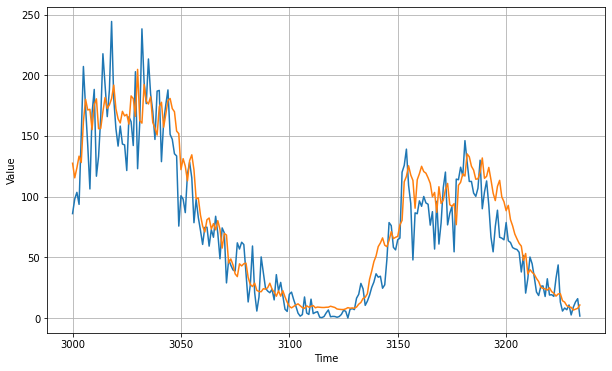

In [33]:
plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid,rnn_forecast)

In [34]:
tf.keras.metrics.mean_absolute_error(x_valid,rnn_forecast).numpy()

16.610058

<Figure size 432x288 with 0 Axes>

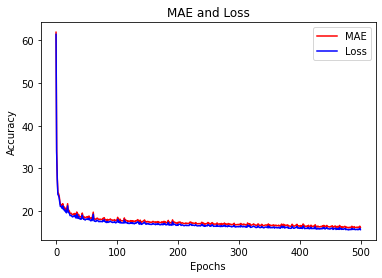

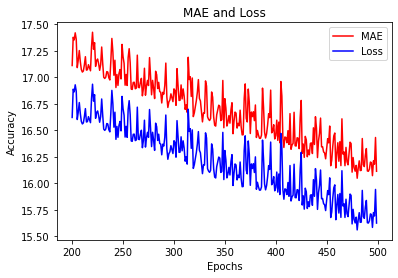

<Figure size 432x288 with 0 Axes>

In [35]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

#Sample Dataset for seq-to-seq model

every day/item is based on its previous prediction, then you have to use the sequence to sequence. (MANY-TO-MANY)

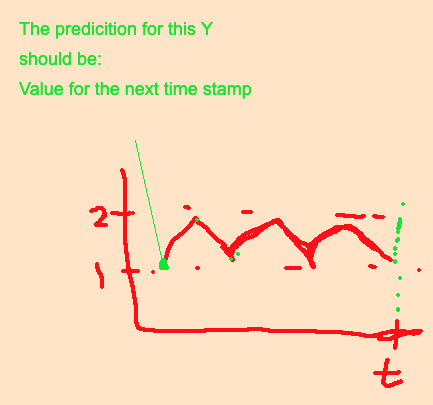

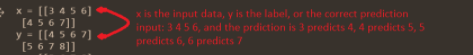

In [74]:
ds = tf.data.Dataset.range(10)
ds = ds.window(5,shift=1,drop_remainder= True) #Putting a sample in a window/ each sample is as a varientDS type
ds = ds.flat_map(lambda w: w.batch(5)) #Putting a sample in a window/ convert it to Tensor
ds = ds.map(lambda w : (w[:-1], w[1:]))
ds = ds.shuffle(buffer_size=10)
ds = ds.batch(2).prefetch(1)


In [75]:
for x, y in ds:
  print("x =", x.numpy())
  print("y =", y.numpy())

x = [[0 1 2 3]
 [4 5 6 7]]
y = [[1 2 3 4]
 [5 6 7 8]]
x = [[3 4 5 6]
 [2 3 4 5]]
y = [[4 5 6 7]
 [3 4 5 6]]
x = [[5 6 7 8]
 [1 2 3 4]]
y = [[6 7 8 9]
 [2 3 4 5]]


#Sample Dataset for Seq-to-Vector Model


In [76]:
ds = tf.data.Dataset.range(10)
ds = ds.window(5,shift=1, drop_remainder=True)
ds = ds.flat_map(lambda w : w.batch(5))
ds = ds.map(lambda w : (w[:-1], w[-1:]))

In [77]:
for x, y in ds:
  print("x =", x.numpy())
  print("y =", y.numpy())

x = [0 1 2 3]
y = [4]
x = [1 2 3 4]
y = [5]
x = [2 3 4 5]
y = [6]
x = [3 4 5 6]
y = [7]
x = [4 5 6 7]
y = [8]
x = [5 6 7 8]
y = [9]
